# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

In [3]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'

# 1) Monolingual (English) word embeddings 

In [4]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt', encoding="utf8") as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        return self.embeddings[self.word2id[word]]
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        encode1, encode2 = self.encode(word1), self.encode(word2)
        return (np.dot(encode1,encode2))/(np.linalg.norm(encode1) * np.linalg.norm(encode2))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort
        result = np.argsort([self.score(word, w) for w in self.words])[-2:-2-k:-1]
        return [self.words[i] for i in result]

In [5]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.2644975466165475
cat dog 0.7078641298542562
cat pet 0.6753313359976381
Paris France 0.6892958925806542
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348005
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [6]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        
        idf = dict.fromkeys(self.word2vec.word2id.keys(),0)
        N = len(sentences)
        for sent in sentences:
            sentence = set(sent.split(" "))
            for w in sentence:
                if w in idf:
                    idf[w] += 1
        idf = {k: np.log(N/(1 + v)) for k, v in idf.items()}
        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        sent = sentence.split(" ")
        if idf is None:
            # mean of word vectors
            return np.mean([self.word2vec.encode(word) for word in sent if word in self.word2vec.word2id], axis = 0)
        else:
            # idf-weighted mean of word vectors
            for word in sent:
                listEmb = [self.word2vec.encode(word) for word in sent if word in self.word2vec.word2id]
                listWeights = [idf[word] for word in sent if word in self.word2vec.word2id]
            return np.average(listEmb, weights = listWeights, axis = 0)

    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        encode1, encode2 = self.encode(sentence1, idf), self.encode(sentence2, idf)
        return (np.dot(encode1,encode2))/(np.linalg.norm(encode1) * np.linalg.norm(encode2))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        result = np.argsort([self.score(sentence, sentenceTrg) for sentenceTrg in sentences])[-2:-2-k:-1]
        return [sentences[i] for i in result]

In [7]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251476
1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6400773156424754
a young boy and 2 girls open christmas presents . 
1) a small boy following 4 geese . 
2) a woman walking with 4 kids . 
3) 2 older women and a young girl with a red bike . 
4) two girls and a boy rollerskating . 
5) a youthful race against 2 asian kids . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [8]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        commonWords = set(self.fr_word2vec.word2id.keys()).intersection(set(self.en_word2vec.word2id.keys()))
        X = np.zeros((self.fr_word2vec.embeddings.shape[1], len(commonWords)))
        Y = np.zeros((self.fr_word2vec.embeddings.shape[1], len(commonWords)))
        for i, word in enumerate(commonWords):
            X[:,i] = self.fr_word2vec.encode(word)
            Y[:,i] = self.en_word2vec.encode(word)
            
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        u, _, vh = np.linalg.svd(Y.dot(X.T))
        W = u.dot(vh)
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        f = lambda a,b : np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))
        #f = lambda a,b : np.linalg.norm(a-b)
        resultInd = np.argsort([f(self.aligned_fr_embeddings[self.fr_word2vec.word2id[fr_word]], el) for el in self.en_word2vec.embeddings])[-2:-2-k:-1]
        #resultInd = np.argsort([f(self.aligned_fr_embeddings[self.fr_word2vec.word2id[fr_word]], el) for el in self.en_word2vec.embeddings])[1:k+1]
        return [self.en_word2vec.words[i] for i in resultInd]

In [9]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "kitten"
en: "kitty"
en: "pet"
----------
fr: "chien"
en: "cat"
en: "pet"
en: "pup"
----------
fr: "voiture"
en: "vehicle"
en: "automobile"
en: "motorbike"
----------
fr: "zut"
en: "Ah"
en: "ah"
en: "nope"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [10]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

## Load Train Set
labels_train = []
sentences_train = []
with open(train_filepath, 'r') as f:
    for line in f:
        sentence = line.strip('\n')
        labels_train.append(int(sentence[0]))
        sentences_train.append(sentence[2:])
labels_train = np.array(labels_train)
        
## Load Dev Set
labels_dev = []
sentences_dev = []
with open(dev_filepath, 'r') as f:
    for line in f:
        sentence = line.strip('\n')
        labels_dev.append(int(sentence[0]))
        sentences_dev.append(sentence[2:])
labels_dev = np.array(labels_dev)

## Load Test Set
labels_test = []
sentences_test = []
with open(test_filepath, 'r') as f:
    for line in f:
        sentence = line.strip('\n')
        sentences_test.append(sentence)


In [11]:
# 2 - Encode sentences with the BoV model above

## Encode Train Set
embb_train = np.array([sentence2vec.encode(sentence) for sentence in sentences_train])

## Encode Dev Set
embb_dev = np.array([sentence2vec.encode(sentence) for sentence in sentences_dev])

## Encode Test Set
embb_test = np.array([sentence2vec.encode(sentence) for sentence in sentences_test])

In [12]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

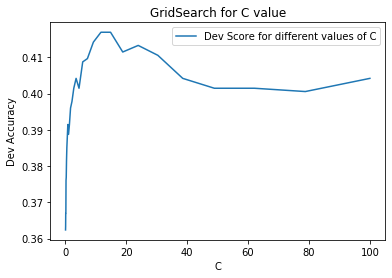

In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

C_test = np.logspace(-1,2,30)
score_test = []

for C in C_test:
    clf = LogisticRegression(C = C, solver='lbfgs', max_iter=1500, multi_class = 'auto').fit(embb_train, labels_train)
    score_test.append(clf.score(embb_dev, labels_dev))

plt.plot(C_test, score_test, label = 'Dev Score for different values of C')
plt.xlabel("C")
plt.ylabel("Dev Accuracy")
plt.title("GridSearch for C value")
plt.legend()

In [14]:
C = C_test[np.argmax(score_test)]
clf = LogisticRegression(C = C, solver='lbfgs', max_iter=2000, multi_class = 'auto').fit(embb_train, labels_train)
print("Cmax value for Average Word Vectors:", C)
print("Training Score Average Word Vectors:", clf.score(embb_train, labels_train))
print("Dev Score Average Word Vectors:",clf.score(embb_dev, labels_dev))

Cmax value for Average Word Vectors: 11.721022975334806
Training Score Average Word Vectors: 0.4674625468164794
Dev Score Average Word Vectors: 0.41689373297002724


#### Accuracy for weighed Average Word Vectors

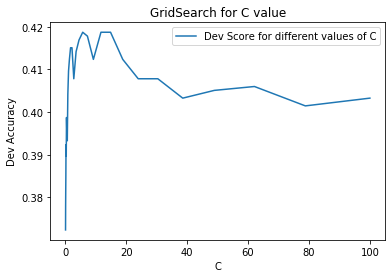

In [15]:
# Build idf scores for words in train and dev set (We are not supposed to see the test set)
idf = sentence2vec.build_idf(sentences_train + sentences_dev)

## Encode Train Set
embbW_train = np.array([sentence2vec.encode(sentence, idf = idf) for sentence in sentences_train])

## Encode Dev Set
embbW_dev = np.array([sentence2vec.encode(sentence, idf = idf) for sentence in sentences_dev])

## Encode Test Set
embbW_test = np.array([sentence2vec.encode(sentence, idf = idf) for sentence in sentences_test])

C_testW = np.logspace(-1,2,30)
score_testW = []

for C in C_testW:
    clf = LogisticRegression(C = C, solver='lbfgs', max_iter=1500, multi_class = 'auto').fit(embbW_train, labels_train)
    score_testW.append(clf.score(embbW_dev, labels_dev))

plt.plot(C_testW, score_testW, label = 'Dev Score for different values of C')
plt.xlabel("C")
plt.ylabel("Dev Accuracy")
plt.title("GridSearch for C value")
plt.legend()

In [16]:
C = C_testW[np.argmax(score_testW)]
clf = LogisticRegression(C = C, solver='lbfgs', max_iter=2000, multi_class = 'auto').fit(embbW_train, labels_train)
print("Cmax value for Weighted Average Word Vectors:", C)
print("Training Score Weighted Average Word Vectors:", clf.score(embbW_train, labels_train))
print("Dev Score Weighted Average Word Vectors:",clf.score(embbW_dev, labels_dev))

Cmax value for Weighted Average Word Vectors: 5.736152510448679
Training Score Weighted Average Word Vectors: 0.46875
Dev Score Weighted Average Word Vectors: 0.4187102633969119


In [17]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

## We take C for the embedding with idf weighed average since it gives slighlty better scores, and we use the train and dev set for training
C = C_testW[np.argmax(score_testW)]
clf = LogisticRegression(C = C, solver='lbfgs', max_iter=2000, multi_class = 'auto').fit(np.concatenate((embbW_train, embbW_dev), axis = 0), np.concatenate((labels_train, labels_dev)))
labels_test = clf.predict(embbW_test).astype(int)
np.savetxt("logreg_bov_y_test_sst.txt", labels_test, fmt='%i', delimiter=",")

In [18]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

### Other Classification Models

#### Support Vector Machine

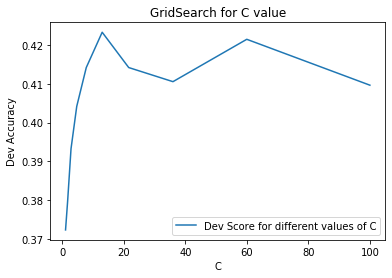

In [19]:
from sklearn.svm import SVC
C_testSVM = np.logspace(0,2,10)
score_testSVM = []

for C in C_testSVM:
    clf = SVC(C = C, kernel = 'linear').fit(embb_train, labels_train)
    score_testSVM.append(clf.score(embb_dev, labels_dev))

plt.plot(C_testSVM, score_testSVM, label = 'Dev Score for different values of C')
plt.xlabel("C")
plt.ylabel("Dev Accuracy")
plt.title("GridSearch for C value")
plt.legend()

In [20]:
C = C_testSVM[np.argmax(score_testSVM)]
clf = SVC(C = C, kernel = 'linear').fit(embb_train, labels_train)
print("Cmax value for Average Word Vectors SVM:", C)
print("Training Score Average Word Vectors SVM:", clf.score(embb_train, labels_train))
print("Dev Score Average Word Vectors SVM:",clf.score(embb_dev, labels_dev))

Cmax value for Average Word Vectors SVM: 12.91549665014884
Training Score Average Word Vectors SVM: 0.4657069288389513
Dev Score Average Word Vectors SVM: 0.4232515894641235


#### Random Forest

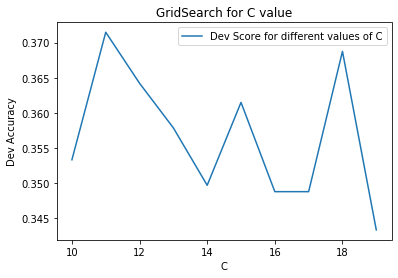

In [21]:
from sklearn.ensemble import RandomForestClassifier
C_testRFM = range(10,20)
score_testRFM = []

for el in C_testRFM:
    clf = RandomForestClassifier(max_depth=el, n_estimators=100).fit(embb_train, labels_train)
    score_testRFM.append(clf.score(embb_dev, labels_dev))


plt.plot(C_testRFM, score_testRFM, label = 'Dev Score for different values of C')
plt.xlabel("C")
plt.ylabel("Dev Accuracy")
plt.title("GridSearch for C value")
plt.legend()

In [22]:
el = C_testRFM[np.argmax(score_testRFM)]
clf = RandomForestClassifier(max_depth=el).fit(embb_train, labels_train)
print("Cmax value for Average Word Vectors SVM:", el)
print("Training Score Average Word Vectors SVM:", clf.score(embb_train, labels_train))
print("Dev Score Average Word Vectors SVM:",clf.score(embb_dev, labels_dev))

c:\users\33617\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Cmax value for Average Word Vectors SVM: 11
Training Score Average Word Vectors SVM: 0.7806647940074907
Dev Score Average Word Vectors SVM: 0.2924613987284287


#### Prevision : SVM

In [23]:
C = C_testSVM[np.argmax(score_testSVM)]
clf = SVC(C = C, kernel = 'linear').fit(np.concatenate((embb_train,embb_dev), axis = 0), np.concatenate((labels_train, labels_dev)))
labels_testSVM = clf.predict(embb_test).astype(int)
np.savetxt("svm_bov_y_test_sst.txt", labels_testSVM, fmt='%i', delimiter=",")

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [34]:
import tensorflow as tf

In [35]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=50000, oov_token=50001)
tokenizer.fit_on_texts(sentences_train)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [36]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/
sentences_train_int = tokenizer.texts_to_sequences(sentences_train)
x_train = tf.keras.preprocessing.sequence.pad_sequences(sentences_train_int, maxlen=35, padding='post', truncating='post')

sentences_dev_int = tokenizer.texts_to_sequences(sentences_dev)
x_dev = tf.keras.preprocessing.sequence.pad_sequences(sentences_dev_int, maxlen=35, padding='post', truncating='post')

sentences_test_int = tokenizer.texts_to_sequences(sentences_test)
x_test = tf.keras.preprocessing.sequence.pad_sequences(sentences_test_int, maxlen=35, padding='post', truncating='post')

In [37]:
print(np.max([np.max(l) for l in sentences_test_int]))

15338


## 4.2 - Design and train your model

W0207 15:47:03.170137   244 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          1600064   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 1,625,221
Trainable params: 1,625,221
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/30
8544/8544 [==============================] - 8s 961us/sample - loss: 1.5747 - acc: 0.2667 - val_loss: 1.5731 - val_acc: 0.2661
Epoch 2/30
8544/8544 [==============================] - 7s 875us/sample - loss: 1.5688 - acc: 0.2732 - val_loss: 1.5747 - val_acc: 0.2534
Epoch 3/30
8544/8544 [=======================

W0207 15:51:03.250989   244 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          3200128   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 3,233,477
Trainable params: 3,233,477
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/30
8544/8544 [==============================] - 9s 1ms/sample - loss: 1.5758 - acc: 0.2647 - val_loss: 1.5748 - val_acc: 0.2516
Epoch 2/30
8544/8544 [==============================] - 8s 942us/sample - loss: 1.5692 - acc: 0.2747 - val_loss: 1.5734 - val_acc: 0.2598
Epoch 3/30
8544/8544 [=========================

W0207 15:55:16.400664   244 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 96)          4800192   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 4,841,733
Trainable params: 4,841,733
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/30
8544/8544 [==============================] - 9s 1ms/sample - loss: 1.5752 - acc: 0.2573 - val_loss: 1.5749 - val_acc: 0.2607
Epoch 2/30
8544/8544 [==============================] - 9s 1ms/sample - loss: 1.5677 - acc: 0.2749 - val_loss: 1.5776 - val_acc: 0.2607
Epoch 3/30
8544/8544 [===========================

W0207 15:59:44.068034   244 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         6400256   
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 6,449,989
Trainable params: 6,449,989
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/30
8544/8544 [==============================] - 9s 1ms/sample - loss: 1.5746 - acc: 0.2602 - val_loss: 1.5738 - val_acc: 0.2534
Epoch 2/30
8544/8544 [==============================] - 9s 1ms/sample - loss: 1.5687 - acc: 0.2667 - val_loss: 1.5753 - val_acc: 0.2534
Epoch 3/30
8544/8544 [===========================

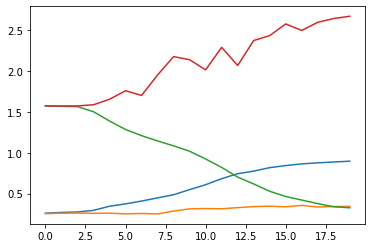

In [42]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dimList  = [32, 64,96,128]  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50002  # size of the vocabulary
n_classes  = 5


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

lErrorAcc = []
lErrorValAcc = []
lErrorLoss = []
lErrorValLoss = []

for embed_dim in embed_dimList:

    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim))
    model.add(LSTM(nhid, dropout=0.4, recurrent_dropout=0.2))
    model.add(Dense(n_classes, activation='softmax'))


    # 4 - Define your loss/optimizer/metrics

    # MODIFY CODE BELOW

    loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
    optimizer        =  'adam' # find the right optimizer
    metrics_classif  =  ['accuracy']

    # Observe how easy (but blackboxed) this is in Keras
    model.compile(loss=loss_classif,
                  optimizer=optimizer,
                  metrics=metrics_classif)
    print(model.summary())


    # 5 - Train your model and find the best hyperparameters for your dev set
    #     you will be evaluated on the quality of your predictions on the test set
    #     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)
    # ADAPT CODE BELOW
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import ModelCheckpoint

    bs = 64
    n_epochs = 30

    y_train = to_categorical([int(i) for i in labels_train], num_classes=5)
    y_dev = to_categorical([int(i) for i in labels_dev], num_classes=5)

    history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev),
                       callbacks=[ModelCheckpoint("weights.{epoch:02d}-{val_acc:.2f}.hdf5", monitor='val_acc',
                                                  save_weights_only=True)])
    lErrorAcc.append(history.history['acc'])
    lErrorValAcc.append(history.history['val_acc'])
    lErrorLoss.append(history.history['loss'])
    lErrorValLoss.append(history.history['val_loss'])

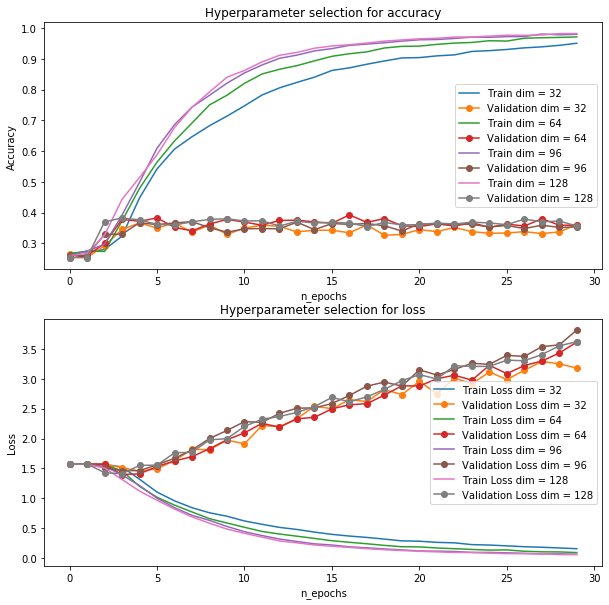

In [51]:
fig, axs = plt.subplots(2, figsize = (10,10))
for i,el in enumerate(embed_dimList):
    axs[0].plot(range(n_epochs), lErrorAcc[i], label = "Train dim = " + str(el))
    axs[0].plot(range(n_epochs), lErrorValAcc[i],'o-', label = "Validation dim = " + str(el))
axs[0].set_xlabel("n_epochs")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Hyperparameter selection for accuracy")
axs[0].legend()
for i,el in enumerate(embed_dimList):
    axs[1].plot(range(n_epochs), lErrorLoss[i], label = "Train Loss dim = " + str(el))
    axs[1].plot(range(n_epochs), lErrorValLoss[i],'o-', label = "Validation Loss dim = " + str(el))
axs[1].set_xlabel("n_epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Hyperparameter selection for loss")
axs[1].legend()
plt.savefig("plotDeep.png")

In [54]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 64  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50002  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.4, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))


# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())


# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)
# ADAPT CODE BELOW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

bs = 64
n_epochs = 10

y_train = to_categorical([int(i) for i in labels_train], num_classes=5)
y_dev = to_categorical([int(i) for i in labels_dev], num_classes=5)

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev),
                   callbacks=[ModelCheckpoint("weights.{epoch:02d}-{val_acc:.2f}.hdf5", monitor='val_acc',
                                              save_weights_only=True)])

W0207 16:17:54.190644   244 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          3200128   
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 3,233,477
Trainable params: 3,233,477
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 9s 1ms/sample - loss: 1.5738 - acc: 0.2701 - val_loss: 1.5800 - val_acc: 0.2534
Epoch 2/10
8544/8544 [==============================] - 8s 921us/sample - loss: 1.5682 - acc: 0.2705 - val_loss: 1.5716 - val_acc: 0.2534
Epoch 3/10
8544/8544 [=========================

In [55]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

#model.load_weights("")

# Sanity check
model.evaluate(x_dev, y_dev)

preds = model.predict(x_test)
preds = preds.argmax(axis = 1)
np.savetxt("logreg_lstm_y_test_sst.txt", preds, fmt='%s')

1101/1101 [==============================] - 1s 459us/sample - loss: 1.9223 - acc: 0.3860


## 4.3 - innovate !

In [57]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras import optimizers

# 1D CNN with 2 branches
# https://arxiv.org/pdf/1510.03820.pdf

def cnn_branch(n_filters, k_size, d_rate, my_input):
    layer_a = Conv1D(n_filters, k_size)(my_input)
    layer_b = GlobalMaxPooling1D()(layer_a)
    return Dropout(d_rate)(layer_b)

# Parameters
embed_dim = 128
nb_branches = 4
nb_filters = 50
filter_sizes = [2, 3, 4, 5]
drop_rate = 0.4 # amount of dropout regularization
vocab_size = 50002
n_classes  = 5
batch_size = 32
nb_epochs = 15
adam = optimizers.Adam(learning_rate=0.0001)

# Architecture

doc_ints = Input(shape=(None,))
doc_wv = Embedding(vocab_size, embed_dim)(doc_ints)
doc_wv_dr = Dropout(drop_rate)(doc_wv)

branch_outputs = []
for idx in range(nb_branches):
    branch_outputs.append(cnn_branch(nb_filters, filter_sizes[idx], drop_rate, doc_wv_dr))

concat = Concatenate()(branch_outputs) # branch output combination
preds = Dense(n_classes, activation='softmax')(concat)

model = Model(doc_ints,preds)

model.compile(optimizer = adam,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

history = model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=nb_epochs, validation_data=(x_dev, y_dev),
                    callbacks=[ModelCheckpoint("weights.1Dconv.{epoch:02d}-{val_acc:.2f}.hdf5", monitor='val_acc',
                                               save_best_only=True, save_weights_only=True)])

W0207 16:23:40.228566   244 training.py:593] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 128)    6400256     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, None, 128)    0           embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, None, 50)     12850       dropout_5[0][0]                  
____________________________________________________________________________________________

In [58]:
preds = model.predict(x_test)
preds = preds.argmax(axis = 1)
np.savetxt("logreg_1Dconv_y_test_sst.txt", preds, fmt='%s')